In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import  OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

# matplotlib에 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS용 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

In [25]:
# 현재 작업 디렉토리 경로를 가져와 shared codes 폴더의 위치를 sys.path에 추가합니다.
# sys.path에 추가된 경로에 있는 py 폴더는 임포트할 수 있다.
current_dir = os.getcwd()
shared_codes_dir = os.path.join(current_dir, '../shared codes')
sys.path.append(shared_codes_dir)

# cover_nan 모듈을 임포트
from cover_nan_0215_dahun import missing_value_removal_function

# 원본 train 데이터 로드
train = pd.read_csv("../shared codes/data/train.csv")
test = pd.read_csv("../shared codes/data/test.csv")

# missing_value_removal_function 사용
train_young, train_middle, train_old, train_unknown = missing_value_removal_function(train)
test_young, test_middle, test_old, test_unknown = missing_value_removal_function(test)

✅ '대리모 여부' 결측값을 최빈값 (0.0) 으로 대체 완료!
✅ 컬럼 삭제 완료: ['PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일', '배아 해동 경과일']
✅ '난자 채취 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '난자 혼합 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '배아 이식 경과일' 결측값을 중앙값 (3.0) 으로 대체 완료!
✅ '대리모 여부' 결측값을 최빈값 (0.0) 으로 대체 완료!
✅ 컬럼 삭제 완료: ['PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일', '배아 해동 경과일']
✅ '난자 채취 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '난자 혼합 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '배아 이식 경과일' 결측값을 중앙값 (3.0) 으로 대체 완료!


In [26]:
def data_preprocessing(train, test):
    index_train = train['idx']
    X = train.drop(['임신 성공 여부', 'idx'], axis=1)
    y = train['임신 성공 여부']

    index_test = test['idx'].copy()  # Ensure a copy is made to prevent any shared memory issues
    test = test.drop('idx', axis=1)

    # 불필요한 칼럼 삭제
    columns_to_drop = [
        "남성 주 불임 원인",
        "남성 부 불임 원인",
        "불임 원인 - 정자 농도",
        "불임 원인 - 정자 면역학적 요인",
        "불임 원인 - 정자 운동성",
        "불임 원인 - 정자 형태",
        '배란 유도 유형'
    ]
    X_train_reduced = X.drop(columns=columns_to_drop)    
    X_test_reduced = test.drop(columns=columns_to_drop)

    numeric_features = [
        '총 생성 배아 수',
        '미세주입된 난자 수',
        '미세주입에서 생성된 배아 수',
        '이식된 배아 수',
        '미세주입 배아 이식 수',
        '저장된 배아 수',
        '미세주입 후 저장된 배아 수',
        '해동된 배아 수',
        '해동 난자 수',
        '수집된 신선 난자 수',
        '저장된 신선 난자 수',
        '혼합된 난자 수',
        '파트너 정자와 혼합된 난자 수',
        '기증자 정자와 혼합된 난자 수',
        '난자 혼합 경과일',
        '배아 이식 경과일'
    ]   
    
    # 데이터 정규화 (수치형 데이터만 정규화)
    # numeric_features = X_train_reduced.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X_train_scaled = X_train_reduced.copy()
    X_test_scaled = X_test_reduced.copy()
    X_train_scaled[numeric_features] = scaler.fit_transform(X_train_reduced[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test_reduced[numeric_features])

    # 인덱스 추가
    X_train_scaled['idx'] = index_train.reset_index(drop=True)
    X_test_scaled['idx'] = index_test.reset_index(drop=True)

    return X_train_scaled, X_test_scaled, y

In [28]:
from catboost import CatBoostClassifier
import pandas as pd

def train_catboost_model(X_train_scaled, y, X_test_scaled):
    # CatBoost 모델 정의
    model = CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.1,
        loss_function='Logloss',
        verbose=100,
        random_seed=42
    )

    # 모델 학습
    model.fit(X_train_scaled, y)

    # 예측 확률
    pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # 제출용 데이터프레임 생성
    submission = pd.DataFrame({
        'probability': pred_proba,
        'idx': X_test_scaled['idx']
    })

    return submission

In [29]:
train_young, train_middle, train_old, train_unknown = missing_value_removal_function(train)
test_young, test_middle, test_old, test_unknown = missing_value_removal_function(test)

X_train_encoded_young, X_test_encoded_young, y_young = data_preprocessing(train_young, test_young)
X_train_encoded_middle, X_test_encoded_middle, y_middle = data_preprocessing(train_middle, test_middle)
X_train_encoded_old, X_test_encoded_old, y_old = data_preprocessing(train_old, test_old)

submission_young = train_catboost_model(X_train_encoded_young, y_young, X_test_encoded_young)
submission_middle = train_catboost_model(X_train_encoded_middle, y_middle, X_test_encoded_middle)
submission_old = train_catboost_model(X_train_encoded_old, y_old, X_test_encoded_old)

# test_unknown의 데이터 개수만큼 0으로 채워진 submission_unknown 생성
submission_unknown = pd.DataFrame({
    'probability': [0] * len(test_unknown),
    'idx': test_unknown['idx']
})

submission = pd.concat([submission_young, submission_middle, submission_old, submission_unknown])

submission = submission.sort_values('idx').reset_index(drop=True)
submission = submission.drop(columns=['idx'])

submission['ID'] = [f"TEST_{i:05d}" for i in range(len(submission))]

submission = submission[['ID', 'probability']]

submission.to_csv("results/submission.csv", index=False)



✅ '대리모 여부' 결측값을 최빈값 (0.0) 으로 대체 완료!
✅ 컬럼 삭제 완료: ['PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일', '배아 해동 경과일']
✅ '난자 채취 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '난자 혼합 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '배아 이식 경과일' 결측값을 중앙값 (3.0) 으로 대체 완료!
✅ '대리모 여부' 결측값을 최빈값 (0.0) 으로 대체 완료!
✅ 컬럼 삭제 완료: ['PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일', '배아 해동 경과일']
✅ '난자 채취 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '난자 혼합 경과일' 결측값을 중앙값 (0.0) 으로 대체 완료!
✅ '배아 이식 경과일' 결측값을 중앙값 (3.0) 으로 대체 완료!


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="TRAIN_000000": Cannot convert 'b'TRAIN_000000'' to float

In [5]:
X_train_encoded_young.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113727 entries, 0 to 256346
Data columns (total 52 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                113727 non-null  object 
 1   시술 시기 코드          113727 non-null  object 
 2   시술 유형             113727 non-null  object 
 3   특정 시술 유형          113727 non-null  object 
 4   배란 자극 여부          113727 non-null  int64  
 5   단일 배아 이식 여부       113727 non-null  float64
 6   여성 주 불임 원인        113727 non-null  int64  
 7   여성 부 불임 원인        113727 non-null  int64  
 8   부부 주 불임 원인        113727 non-null  int64  
 9   부부 부 불임 원인        113727 non-null  int64  
 10  불명확 불임 원인         113727 non-null  int64  
 11  불임 원인 - 난관 질환     113727 non-null  int64  
 12  불임 원인 - 남성 요인     113727 non-null  int64  
 13  불임 원인 - 배란 장애     113727 non-null  int64  
 14  불임 원인 - 여성 요인     113727 non-null  int64  
 15  불임 원인 - 자궁경부 문제   113727 non-null  int64  
 16  불임 원인 - 자궁내막증     113727 

In [ ]:
# train 데이터프레임에서 '시술 시기 코드'

In [30]:
X_train_encoded_young['시술 시기 코드'].value_counts()

시술 시기 코드
TRCMWS    16888
TRDQAZ    16696
TRJXFG    16503
TRYBLT    16458
TRVNRY    16386
TRZKPL    15811
TRXQMD    14985
Name: count, dtype: int64

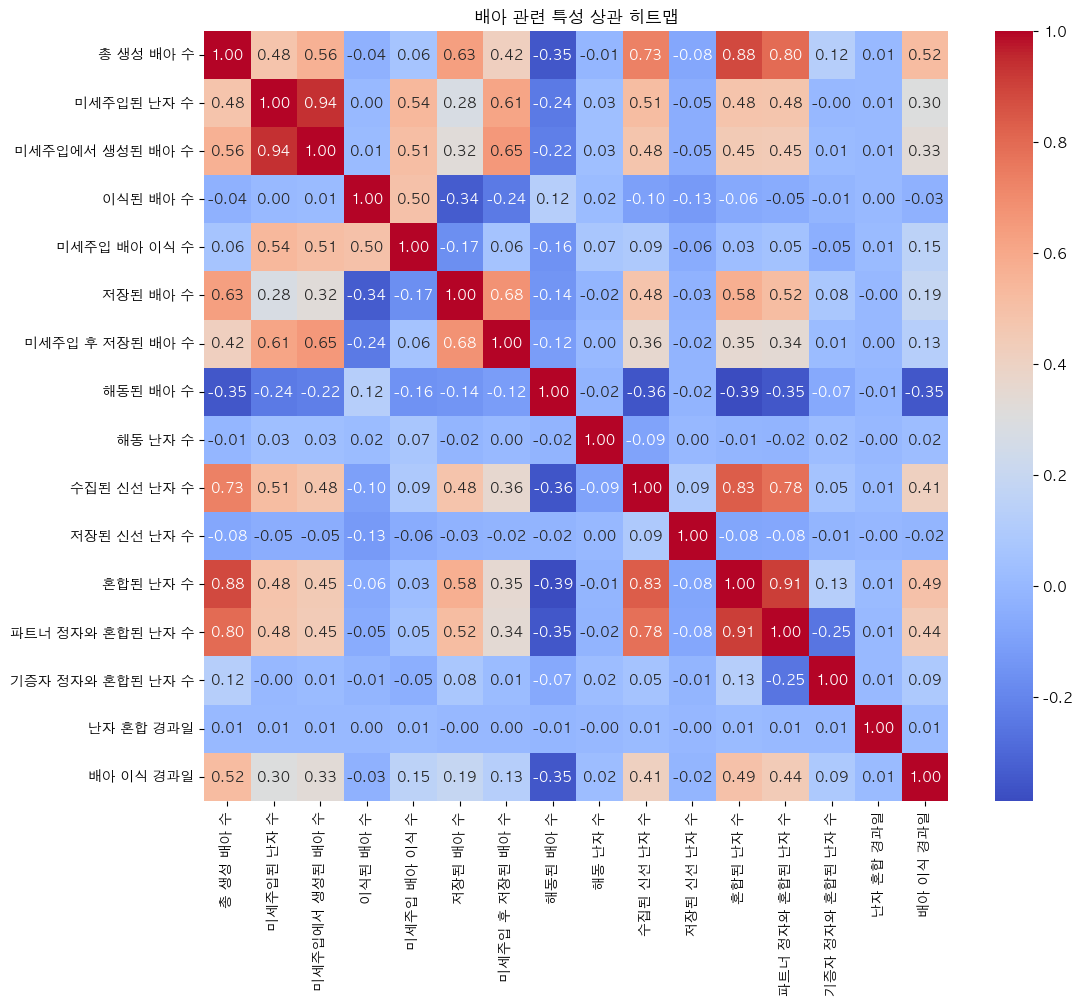

In [7]:


def plot_correlation_heatmap(dataframe, title="Correlation Heatmap"):
    # 수치형 변수 선택
    numeric_df = dataframe.select_dtypes(include=[np.number])
    
    # 상관 행렬 계산
    correlation_matrix = numeric_df.corr()
    
    # 히트맵 그리기
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.show()

embryo_related_columns = [
    '총 생성 배아 수',
    '미세주입된 난자 수',
    '미세주입에서 생성된 배아 수',
    '이식된 배아 수',
    '미세주입 배아 이식 수',
    '저장된 배아 수',
    '미세주입 후 저장된 배아 수',
    '해동된 배아 수',
    '해동 난자 수',
    '수집된 신선 난자 수',
    '저장된 신선 난자 수',
    '혼합된 난자 수',
    '파트너 정자와 혼합된 난자 수',
    '기증자 정자와 혼합된 난자 수',
    '난자 혼합 경과일',
    '배아 이식 경과일'
]

# 관련된 컬럼만 선택하여 상관 분석 수행
plot_correlation_heatmap(X_train_encoded_young[embryo_related_columns], title="배아 관련 특성 상관 히트맵")

In [8]:
import pandas as pd
import numpy as np

# 상관계수 쌍 프린트 함수
def print_high_correlation_pairs(df, threshold=0.7):
    # 상관 행렬 계산
    corr_matrix = df.corr().abs()

    # 주 대각선을 기준으로 윗부분만 탐색
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    print("컬럼 쌍                      상관계수")
    # 상관계수가 threshold보다 큰 쌍 찾기
    for col_A in upper_triangle.columns:
        for col_B in upper_triangle.index:
            if upper_triangle.loc[col_B, col_A] > threshold:
                print(f"{col_A} - {col_B}          {upper_triangle.loc[col_B, col_A]:.2f}")

# 수치형 데이터프레임 추출
numeric_df = X_train_encoded_young[embryo_related_columns]

# 상관계수의 절댓값이 0.7 이상인 쌍 프린트
print_high_correlation_pairs(numeric_df, threshold=0.7)

컬럼 쌍                      상관계수
미세주입에서 생성된 배아 수 - 미세주입된 난자 수          0.94
수집된 신선 난자 수 - 총 생성 배아 수          0.73
혼합된 난자 수 - 총 생성 배아 수          0.88
혼합된 난자 수 - 수집된 신선 난자 수          0.83
파트너 정자와 혼합된 난자 수 - 총 생성 배아 수          0.80
파트너 정자와 혼합된 난자 수 - 수집된 신선 난자 수          0.78
파트너 정자와 혼합된 난자 수 - 혼합된 난자 수          0.91


0:	learn: 0.6544460	total: 76.5ms	remaining: 7.57s
50:	learn: 0.5543098	total: 834ms	remaining: 801ms
99:	learn: 0.5521560	total: 1.58s	remaining: 0us


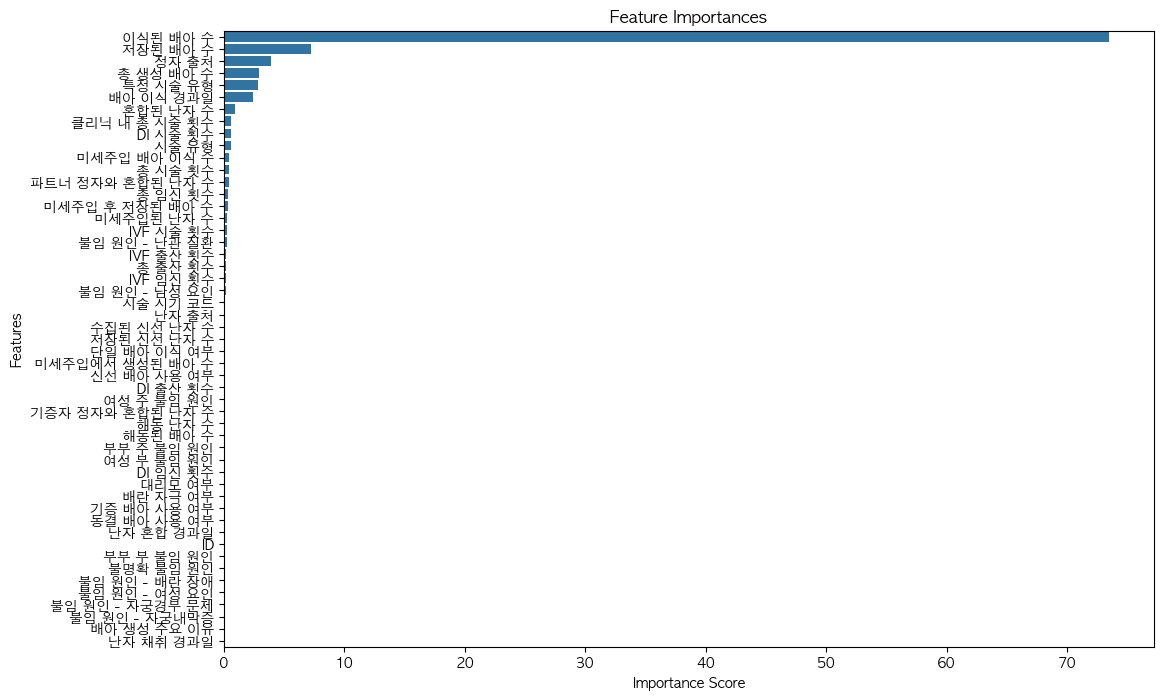

In [9]:
from catboost import CatBoostClassifier

# 범주형 변수의 인덱스를 리스트로 변환
categorical_features_indices = X_train_encoded_young.select_dtypes(include=['object', 'bool']).columns.tolist()

# CatBoost 모델 정의
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, cat_features=categorical_features_indices, verbose=50, random_seed=42)

# 모델 학습에 필요한 피처만 선택
X_train = X_train_encoded_young.drop(columns=['idx'])

# 모델 학습
model.fit(X_train, y_young)

# 피처 중요도 추출
feature_importances = model.get_feature_importance(prettified=True)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importances(feature_importances):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importances', y='Feature Id', data=feature_importances)
    plt.title('Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

plot_feature_importances(feature_importances)

In [10]:
feature_importances

,Feature Id,Importances
0,이식된 배아 수,73.508598
1,저장된 배아 수,7.242776
2,정자 출처,3.881724
3,총 생성 배아 수,2.935032
4,특정 시술 유형,2.820492
5,배아 이식 경과일,2.451813
6,혼합된 난자 수,0.930055
7,클리닉 내 총 시술 횟수,0.626187
8,DI 시술 횟수,0.604532
9,시술 유형,0.592159


In [11]:
import pandas as pd
import numpy as np

def calculate_target_correlations(dataframe, target_data, target_name):
    # 수치형 데이터만 선택
    numeric_df = dataframe.select_dtypes(include=[np.number]).copy()
    numeric_df[target_name] = target_data  # 타겟 값을 데이터프레임에 추가

    # 모든 변수와 타겟 변수 간의 상관계수 계산
    correlations = numeric_df.corr()[target_name].drop(target_name)  # 타겟 자신의 상관계수 제외

    # 상관계수를 절댓값 기준으로 정렬
    sorted_correlations = correlations.abs().sort_values(ascending=False)

    # 상관계수 출력
    print("컬럼과 타겟 컬럼의 상관계수 (절댓값 기준 정렬):")
    for column_name, correlation_value in sorted_correlations.items():
        print(f"{column_name}: {correlation_value:.4f} ({correlations[column_name]:.4f})")

# 타겟 컬럼 데이터 설정
y_young = pd.Series(y_young)  # y_young이 기본적으로 Series여야 합니다.
y_young.name = 'Target'  # target 데이터의 이름 설정

# 상관관계 계산 및 출력
calculate_target_correlations(X_train_encoded_young, y_young, 'Target')

컬럼과 타겟 컬럼의 상관계수 (절댓값 기준 정렬):
이식된 배아 수: 0.1982 (0.1982)
배아 이식 경과일: 0.1651 (0.1651)
단일 배아 이식 여부: 0.1213 (0.1213)
총 생성 배아 수: 0.1012 (0.1012)
미세주입 배아 이식 수: 0.0984 (0.0984)
배아 생성 주요 이유: 0.0685 (0.0685)
신선 배아 사용 여부: 0.0663 (0.0663)
혼합된 난자 수: 0.0654 (0.0654)
미세주입에서 생성된 배아 수: 0.0594 (0.0594)
동결 배아 사용 여부: 0.0553 (-0.0553)
파트너 정자와 혼합된 난자 수: 0.0547 (0.0547)
저장된 신선 난자 수: 0.0481 (-0.0481)
배란 자극 여부: 0.0444 (0.0444)
미세주입된 난자 수: 0.0381 (0.0381)
수집된 신선 난자 수: 0.0324 (0.0324)
해동된 배아 수: 0.0310 (-0.0310)
불임 원인 - 남성 요인: 0.0274 (0.0274)
기증자 정자와 혼합된 난자 수: 0.0265 (0.0265)
여성 주 불임 원인: 0.0199 (-0.0199)
부부 주 불임 원인: 0.0184 (-0.0184)
미세주입 후 저장된 배아 수: 0.0114 (-0.0114)
불임 원인 - 난관 질환: 0.0097 (-0.0097)
저장된 배아 수: 0.0096 (-0.0096)
부부 부 불임 원인: 0.0092 (-0.0092)
여성 부 불임 원인: 0.0091 (-0.0091)
불명확 불임 원인: 0.0088 (0.0088)
기증 배아 사용 여부: 0.0073 (0.0073)
해동 난자 수: 0.0045 (-0.0045)
대리모 여부: 0.0042 (-0.0042)
불임 원인 - 자궁경부 문제: 0.0041 (-0.0041)
난자 혼합 경과일: 0.0041 (-0.0041)
idx: 0.0020 (0.0020)
불임 원인 - 배란 장애: 0.0011 (0.0011)
불임 원인 - 자궁내막증: 0

In [17]:
import pandas as pd

# 데이터프레임 예시
# X_train_encoded_young = X_train_encoded_young  # 실제 데이터를 사용해주세요

# "총 생성 배아 수"와 "이식된 배아 수"가 같은 행 필터링
same_embryo_rows = train[(train['총 생성 배아 수'] < train['이식된 배아 수']) & (train['이식된 배아 수'] > 0)]

# '단일 배아 이식 여부' == 1이고 '이식된 배아 수' > 0인 행 필터링
single_embryo_rows = train[(train['단일 배아 이식 여부'] == 1) & (train['이식된 배아 수'] != 1)]





# 필터링된 결과 출력
print(single_embryo_rows[['총 생성 배아 수', '이식된 배아 수', '단일 배아 이식 여부', '임신 성공 여부', '난자 출처', '정자 출처']])

        총 생성 배아 수  이식된 배아 수  단일 배아 이식 여부  임신 성공 여부  난자 출처   정자 출처
8306          0.0       3.0          1.0         0  본인 제공     미할당
20369         0.0       2.0          1.0         0  본인 제공  배우자 제공
32660         4.0       2.0          1.0         0  본인 제공  배우자 제공
43602        11.0       2.0          1.0         0  본인 제공  배우자 제공
59050         5.0       2.0          1.0         0  본인 제공  배우자 제공
68931         7.0       2.0          1.0         0  본인 제공  배우자 제공
105380        4.0       2.0          1.0         0  본인 제공  배우자 제공
110043       12.0       2.0          1.0         0  본인 제공  배우자 제공
110814        0.0       2.0          1.0         0  기증 제공  배우자 제공
112249        0.0       2.0          1.0         1  기증 제공   기증 제공
116623        5.0       2.0          1.0         0  본인 제공  배우자 제공
123649        0.0       2.0          1.0         0  본인 제공  배우자 제공
133419        6.0       2.0          1.0         1  기증 제공  배우자 제공
144411        0.0       2.0          1.0         0  본인 제공  배우자 제공
154122    

In [15]:
# '단일 배아 이식 여부' == 1이고 '이식된 배아 수' > 0인 행 필터링
single_embryo_rows = test[(test['단일 배아 이식 여부'] == 1) & (test['이식된 배아 수'] != 1)]





# 필터링된 결과 출력
print(single_embryo_rows[['총 생성 배아 수', '이식된 배아 수', '단일 배아 이식 여부', '난자 출처', '정자 출처']])

       총 생성 배아 수  이식된 배아 수  단일 배아 이식 여부  난자 출처   정자 출처
41552       10.0       2.0          1.0  본인 제공  배우자 제공
59077        0.0       2.0          1.0  본인 제공  배우자 제공
66507       13.0       2.0          1.0  본인 제공  배우자 제공
82710        7.0       2.0          1.0  본인 제공  배우자 제공
86539        0.0       2.0          1.0  본인 제공  배우자 제공


In [13]:
train[['총 생성 배아 수', '이식된 배아 수']]

,총 생성 배아 수,이식된 배아 수
0,4.0,2.0
1,0.0,0.0
2,5.0,2.0
3,0.0,0.0
4,6.0,2.0
...,...,...
256346,5.0,2.0
256347,3.0,2.0
256348,6.0,2.0
256349,2.0,2.0


In [22]:
import pandas as pd
import numpy as np

def print_correlation_with_target(dataframe, target_column):
    # 수치형 데이터만 선택
    numeric_df = dataframe.select_dtypes(include=[np.number])
    
    # 타겟 컬럼과의 상관계수 계산
    target_correlations = numeric_df.corr()[target_column].drop(target_column)  # 타겟 자신 제외

    # 상관계수 출력
    print(f"'{target_column}' 컬럼과 다른 수치형 컬럼 간의 상관계수:")
    for column_name, correlation_value in target_correlations.items():
        if abs(correlation_value) >= 0.1:
            print(f"{column_name}: {correlation_value:.4f}")

# 데이터 프레임 설정 (예시로 X_train_encoded_young를 사용)
# df = X_train_encoded_young  # 실제 데이터를 사용할 때 주석 해제

# 상관계수 출력
print_correlation_with_target(train, '이식된 배아 수')

'이식된 배아 수' 컬럼과 다른 수치형 컬럼 간의 상관계수:
단일 배아 이식 여부: -0.2629
착상 전 유전 진단 사용 여부: -0.1013
미세주입 배아 이식 수: 0.4897
저장된 배아 수: -0.2925
미세주입 후 저장된 배아 수: -0.2101
저장된 신선 난자 수: -0.1434
임신 성공 여부: 0.1575


In [23]:
interest_col = [
    '이식된 배아 수',
    '저장된 배아 수',
    '단일 배아 이식 여부',
    '혼합된 난자 수',
    '총 생성 배아 수',
    '배아 생성 주요 이유',
    '미세주입에서 생성된 배아 수',
    '미세주입 배아 이식 수',
    '저장된 배아 수',
    '미세주입 후 저장된 배아 수',
    '동결 배아 사용 여부',
    '신선 배아 사용 여부',
    '기증 배아 사용 여부'
]

df = train[interest_col]

,이식된 배아 수,저장된 배아 수,단일 배아 이식 여부,혼합된 난자 수,총 생성 배아 수,배아 생성 주요 이유,미세주입에서 생성된 배아 수,미세주입 배아 이식 수,저장된 배아 수,미세주입 후 저장된 배아 수,동결 배아 사용 여부,신선 배아 사용 여부,기증 배아 사용 여부
0,2.0,2.0,0.0,5.0,4.0,현재 시술용,4.0,2.0,2.0,2.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,현재 시술용,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0.0,0.0,7.0,5.0,현재 시술용,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,4.0,0.0,현재 시술용,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,6.0,6.0,현재 시술용,6.0,2.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256346,2.0,0.0,0.0,8.0,5.0,현재 시술용,5.0,2.0,0.0,0.0,0.0,1.0,0.0
256347,2.0,0.0,0.0,3.0,3.0,현재 시술용,3.0,2.0,0.0,0.0,0.0,1.0,0.0
256348,2.0,0.0,0.0,6.0,6.0,현재 시술용,6.0,2.0,0.0,0.0,0.0,1.0,0.0
256349,2.0,0.0,0.0,2.0,2.0,현재 시술용,2.0,2.0,0.0,0.0,0.0,1.0,0.0
